## Examining timing side-channel attacks

The idea is to show that time analysis can reveal meaningful information about a string used in a secret or a password if the amount of time it takes to perform the string match isn't buffered. 

This example will be to show how the libc strcmp method reveals information about a secret string and, possibly, the string itself in a brute force attack. We'll be using python code to demonstrate the action and analysis, but this can be performed with any language that uses similar methods.


Our secret string is 'apple'.

A client presents the secret string to the server, who knows the secret string, in an operation that will fail if the secret is incorrect.

So:

Client -> 'apple' -> Server  

Server: 
- receives a buffer containing the string. 
- gets a copy of the secret 
- strcmp's the two strings
    - analyze bytes from l to r
    - when a byte fails, return False
    - if no bytes fail move to next char. 
    - Return True if nothing fails or False when a match fails.
Server ->True/False -> Client 

The problem is that for every correct chunk of text on the LHS the "fail" takes longer to return. Also - longer strings also take longer to return.

So "b" or "broken" returns a failure instantly, but "a", "aplomb", "app", "application", etc will each take slightly longer for each character matched. The times are tiny, but it's possible to model the jitter window such that these lengths don't get lost in the noise. This can drastically cut down the time of a brute force attack and enhance its chances of success.

TL;DR - using sound hash functions which return in a constant time and not rolling-your-own solves this problem.

Also: for authentication purposes it's an antipattern to store the secret plaintext or decode an encrypted secret to compare in plaintext. Hashing the secret, storing the hash then comparing the hashes also obscures the size of your secret by making the compared strings the same lengh, and increasing the problem for a brute force attack.

In [2]:
# need to use attotime here to get fractional nanoseconds
import sys, os, time, string, attotime, secrets, hashlib
from datetime import datetime

# imports
import pandas as pd
import numpy as np

# Viz imports
import matplotlib.pyplot as plt
import seaborn as sns

# Config matplotlib
%matplotlib inline
plt.rcParams["patch.force_edgecolor"] = True # in matplotlib, edge borders are turned off by default.
sns.set_style("darkgrid") # set a grey grid as a background

# turn off warnings
import warnings
warnings.filterwarnings('ignore')


In [3]:
# we only care about urlsafe characters - alpha, numeric, dash and underscore. Omitting . and ~ (RFC 3986)
valid_chars = list(string.ascii_letters)
for x in range(0,10):
    valid_chars.append(str(x))
valid_chars.append('-')
valid_chars.append('_')

In [4]:
def compare1(str1, str2):
    """
    Here we're going to amplify the lib strcmp delays to make the weakness easier to analyze:
    1. evaluate strings l-to-r
    2. dope a positive match with a tiny wait to emphasize the delay for demonstration
    3. return a False match immediately
    """

    one, two = list(str1), list(str2)
    for x in range(0,len(one)):
        if one[x] == two[x]:
            time.sleep(.001)
            pass
        else:
            return False
    return True

### First example - guess the first letter

Here we'll just run through each letter 1k times adding completion time to an array. Then we'll find the longest run of the letters.

The original code here found the longest completion of a string and added it to the "totals" array, then we sorted the longest variant of 'totals'. This would be better if averaged every run, then added that to the dict. 

TODO:
- add mean returns
- add an evaluation loop that then uses that builds the string from the statistical stubs

In [5]:
# in a long string we just want to guess the first character
# mysecret = secrets.token_urlsafe()
mysecret = 'rMAwzI_52tVSvgKzRo3PJ0G7_Danw7jlaZ-6vTkOUiQ'

In [6]:
totals=[]
for loop in range(1000):
    stash = {}
    for l in valid_chars:
        mystr = l *10
        start = attotime.attodatetime.now()
        compare1(mystr, mysecret)
        end = attotime.attodatetime.now()
        duration = end - start
        stash[mystr] = str(duration)


In [7]:
# fastest
sorted(stash.items(), key=lambda x: x[1])[:10]

[('pppppppppp', '0:00:00.00020503997802735'),
 ('oooooooooo', '0:00:00.00020575523376465'),
 ('EEEEEEEEEE', '0:00:00.00020718574523926'),
 ('CCCCCCCCCC', '0:00:00.00020790100097656'),
 ('5555555555', '0:00:00.00020790100097657'),
 ('mmmmmmmmmm', '0:00:00.00020813941955566'),
 ('DDDDDDDDDD', '0:00:00.00020813941955566'),
 ('RRRRRRRRRR', '0:00:00.00020885467529297'),
 ('BBBBBBBBBB', '0:00:00.00020909309387207'),
 ('SSSSSSSSSS', '0:00:00.00020909309387207')]

In [8]:
# slowest returns at the bottom
# note how much slower lower case rrrrrrrrrr (leading character match) is compared to the rest
sorted(stash.items(), key=lambda x: x[1])[-10:]

[('eeeeeeeeee', '0:00:00.00024604797363281'),
 ('XXXXXXXXXX', '0:00:00.00025177001953125'),
 ('MMMMMMMMMM', '0:00:00.00025510787963867'),
 ('6666666666', '0:00:00.00026392936706543'),
 ('----------', '0:00:00.00028324127197266'),
 ('FFFFFFFFFF', '0:00:00.00028610229492187'),
 ('GGGGGGGGGG', '0:00:00.00029516220092774'),
 ('WWWWWWWWWW', '0:00:00.00030899047851562'),
 ('LLLLLLLLLL', '0:00:00.00034999847412109'),
 ('rrrrrrrrrr', '0:00:00.00163507461547851')]

### statistical analysis

Currently incomplete.

We'll run each letter comparison 10 times, then get the mean of those runs. After a loop choose the longest timed character as the next spot on the stub.

In [9]:
stash1 = {}
for l in valid_chars:
    totals=[]
    for loop in range(10):
        #mystr = l *10
        start = attotime.attodatetime.now()
        compare1(l, mysecret)
        end = attotime.attodatetime.now()
        ttime = end - start
        duration = str(ttime).split(':')[2]
        totals.append(float(duration))
        #print(min(totals), max(totals), sum(totals) / len(totals))

    stash1[l] = sum(totals) / len(totals)
        
# sorted(stash1.items(), key=lambda x: x[1])


In [10]:
len(stash1)

64

In [11]:
sorted(stash1.items(), key=lambda x: x[1])[-1]

('r', 0.0015602588653564479)

### visualizing


In [12]:
df = pd.DataFrame(stash.items())

In [13]:
# change the column names 
df.columns = ['string', 'duration']

In [14]:
def fixtimes(time):
    """
    early version where duration was saved as a attotime string
    """
    if isinstance(time, str):
        return float(time.split(':')[2])

In [15]:
# change duration strings to be integers. only use the fractional nanoseconds in this case
df['duration'] = df['duration'].apply(fixtimes)

**the plot**

The plot is mildly borked. I want a list of xticks that show the string at 'x' where the Duration of 'y' is highest, but set_xticklabels doesn't correlate to y vals. Will fix this later. 

That said - you'll see that the high point duration matches the 'rrrrrrrrrr' entry from the data.

Text(0, 0.5, 'duration')

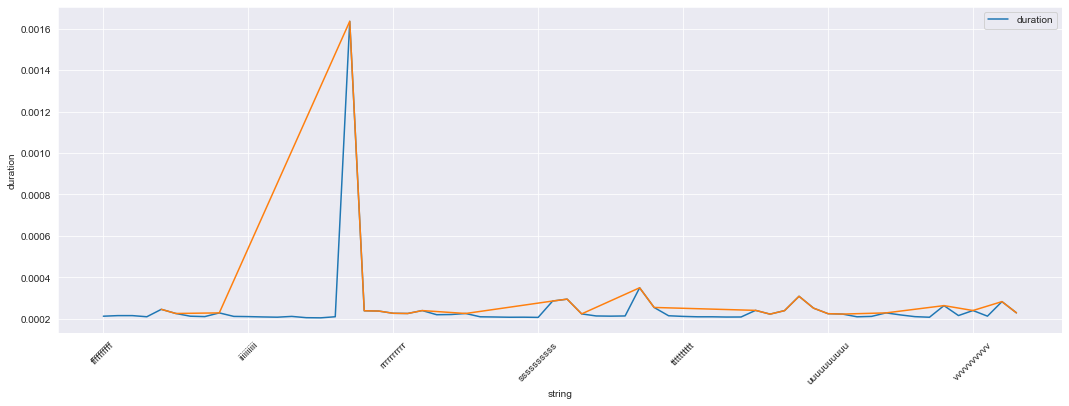

In [16]:
ax = df.plot(figsize=(18,6))
df[df['duration']> .000222]['duration'].plot(figsize=(18,6))
# not mapping strings to duration correctly
plt.xticks(rotation=45)
ax.set_xticklabels(df[df['duration']> .000222]['string'])
#ax.set_xticklabels(df.string.to_list())
# not working as I expected
# ax.set_xlabel(df.string.to_list())
ax.set_xlabel('string')
ax.set_ylabel('duration')

**a histogram shows off the distributions**

Most of the count returns immediately, but you can see on the right where the longest returns are.

<AxesSubplot:xlabel='duration', ylabel='Density'>

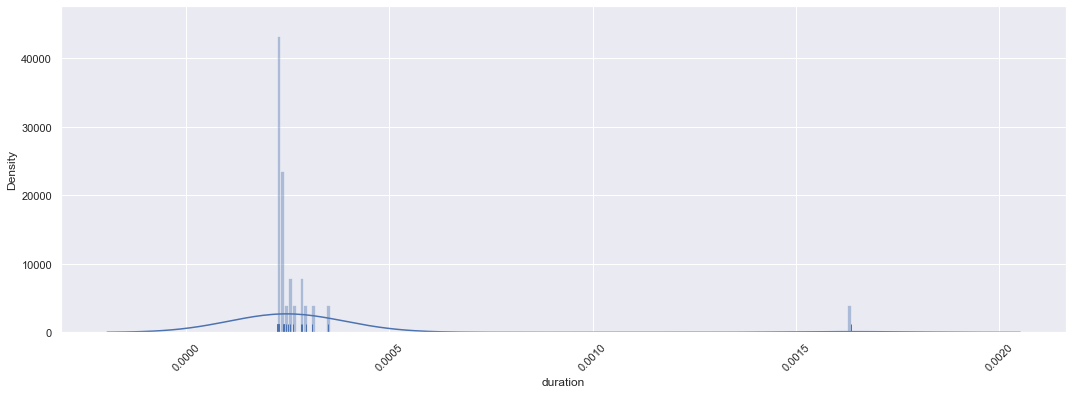

In [17]:
# a histogram shows off how obvious a good match is, compared to jitter
sns.set(rc={'figure.figsize':(18,6)})
plt.xticks(rotation=45)
sns.distplot(df[df['duration']> .000222]['duration'],bins=150, rug=True, kde=True)

## example of brute force strcmp analysis attacks 

Here's a dictionary matcher

In [18]:
# get a built-in dictionary
wordsraw = open('/usr/share/dict/words','r').readlines()
[x.strip('\n') for x in wordsraw]
words = [x.strip('\n') for x in wordsraw]

In [19]:
# set our name as 'apple'
name='apple'
# a longer one
name2 = 'unresourcefulness'

**This can take awhile to run**

Just matching 'apple' from a dictionary of english words. Words farther down the alphabet will take longer.


In [20]:
stash2 = {}
print('starting at:', datetime.now())
runstart = attotime.attodatetime.now()
for w in range(0,len(words)):
    start = attotime.attodatetime.now()
    if compare1(words[w], name):
            if compare1(words[w], name):
                if words[w] == name:
                    print('Name is', words[w])
                    break
            else:
                end = attotime.attodatetime.now()
                duration = end - start
                stash2[words[w]] = str(duration)
                print(words[w])
                stub = s
                break
    else:
        end = attotime.attodatetime.now()
        duration = end - start
        stash2[words[w]] = str(duration)
        pass
runend = attotime.attodatetime.now()
print('Finished. Total time:', runend - runstart)

starting at: 2021-09-17 18:28:24.229185
Name is apple
Finished. Total time: 0:00:23.12203621864318848


In [21]:
sorted(stash2.items(),key=lambda x: x[1])[:10]

[('Angevin', '0:00:00.0002138614654541'),
 ('Amerindic', '0:00:00.00021457672119141'),
 ('Amerindian', '0:00:00.00021481513977051'),
 ('Aaronite', '0:00:00.00021505355834961'),
 ('Americanoid', '0:00:00.00021576881408691'),
 ('Appendiculata', '0:00:00.00021600723266602'),
 ('Anglicanum', '0:00:00.00021672248840332'),
 ('Aeacus', '0:00:00.00021696090698242'),
 ('Americaward', '0:00:00.00021696090698242'),
 ('Angetenar', '0:00:00.00021886825561523')]

### Brute forcing letter by character

using the timing analysis on local alphabet attacks

In [22]:

stash3 = {}
for c in valid_chars:
    stub = c
    for loop in range(0, len(name2)):
        stublist = [stub + l for l in valid_chars]
        for s in stublist:
            start = attotime.attodatetime.now()
            if compare1(s, name2):
                if s == name2:
                    print('Name is', s)
                    break
                else:
                    end = attotime.attodatetime.now()
                    duration = end - start
                    stash3[s] = str(duration)
                    print(s)
                    stub = s
                    break
            else:
                end = attotime.attodatetime.now()
                duration = end - start
                stash3[s] = str(duration)
                pass

un
unr
unre
unres
unreso
unresou
unresour
unresourc
unresource
unresourcef
unresourcefu
unresourceful
unresourcefuln
unresourcefulne
unresourcefulnes
Name is unresourcefulness
Name is unresourcefulness


**The longest returns are at the bottom and correspond to getting closer to the answer**

There is a little jumbling but it's clear that by only focusing on time it clusters better answers together.

In [23]:
# The longest returns are at the bottom and correspond to getting closer to the answer
sorted(stash3.items(), key=lambda x: x[1])[-20:]

[('unresourcefulnesm', '0:00:00.01949715614318847'),
 ('unresourcefulnesa', '0:00:00.01952290534973144'),
 ('unresourcefulneb', '0:00:00.01956582069396973'),
 ('unresourcefulnesk', '0:00:00.0196380615234375'),
 ('unresourcefulnesh', '0:00:00.01964306831359864'),
 ('unresourcefulnesl', '0:00:00.01965808868408203'),
 ('unresourcefulnec', '0:00:00.01977396011352539'),
 ('unresourcefulnesn', '0:00:00.019989013671875'),
 ('unresourcefulnesf', '0:00:00.02000999450683593'),
 ('unresourcefulnesj', '0:00:00.02003812789916992'),
 ('unresourcefulnesi', '0:00:00.02007293701171875'),
 ('unresourcefulnesq', '0:00:00.02025604248046875'),
 ('unresourcefulnesg', '0:00:00.02032208442687989'),
 ('unresourcefulnese', '0:00:00.02042388916015625'),
 ('unresourcefulnee', '0:00:00.02042913436889649'),
 ('unresourcefulnesr', '0:00:00.02044820785522461'),
 ('unresourcefulnesb', '0:00:00.02046108245849609'),
 ('unresourcefulnes', '0:00:00.0205690860748291'),
 ('unresourcefulnesp', '0:00:00.02066922187805176'),
 

**and a modified dictionary word**

In [24]:
name='orang00t4_n'
stash4 = {}
for c in valid_chars:
    stub = c
    for loop in range(0, len(name)):
        stublist = [stub + l for l in valid_chars]
        for s in stublist:
            start = attotime.attodatetime.now()
            if compare1(s, name):
                if s == name:
                    print('Name is', s)
                    break
                else:
                    end = attotime.attodatetime.now()
                    duration = end - start
                    stash4[s] = str(duration)
                    print(s)
                    stub = s
                    break
            else:
                end = attotime.attodatetime.now()
                duration = end - start
                stash4[s] = str(duration)
                pass
            

or
ora
oran
orang
orang0
orang00
orang00t
orang00t4
orang00t4_
Name is orang00t4_n
Name is orang00t4_n


In [25]:
sorted(stash4.items(), key=lambda x: x[1])[-20:]

[('orang00t4_f', '0:00:00.01232790946960449'),
 ('orang00t4A', '0:00:00.01233291625976563'),
 ('orang00t4Q', '0:00:00.01233506202697754'),
 ('orang00t4M', '0:00:00.01236200332641601'),
 ('orang00t4L', '0:00:00.01236224174499512'),
 ('orang00t4_j', '0:00:00.01240086555480957'),
 ('orang00t4J', '0:00:00.01240921020507812'),
 ('orang00t4_c', '0:00:00.01241874694824219'),
 ('orang00t4_g', '0:00:00.01261687278747558'),
 ('orang00t4_d', '0:00:00.01262688636779785'),
 ('orang00t4N', '0:00:00.01263189315795899'),
 ('orang00t46', '0:00:00.01274228096008301'),
 ('orang00t4_e', '0:00:00.01292610168457031'),
 ('orang00t4_b', '0:00:00.0131230354309082'),
 ('orang00t4_a', '0:00:00.01313185691833496'),
 ('orang00t4_i', '0:00:00.01323080062866211'),
 ('orang00t4_k', '0:00:00.01343059539794922'),
 ('orang00t4_l', '0:00:00.01357483863830566'),
 ('orang00t4_m', '0:00:00.01358890533447265'),
 ('orang00t4_', '0:00:00.01370596885681152')]

## Testing the time difference with our long string


This will take slightly longer for a 41 character string, but trivial on a modern laptop.


mysecret = 'rMAwzI_52tVSvgKzRo3PJ0G7_Danw7jlaZ-6vTkOUiQ'

In [26]:
print('starting at:', datetime.now())
runstart = attotime.attodatetime.now()
stash5 = {}
for c in valid_chars:
    stub = c
    for loop in range(0, len(mysecret)):
        stublist = [stub + l for l in valid_chars]
        for s in stublist:
            start = attotime.attodatetime.now()
            if compare1(s, mysecret):
                if s == mysecret:
                    print('Name is', s)
                    break
                else:
                    end = attotime.attodatetime.now()
                    duration = end - start
                    stash5[s] = str(duration)
                    print(s)
                    stub = s
                    break
            else:
                end = attotime.attodatetime.now()
                duration = end - start
                stash5[s] = str(duration)
                pass
runend = attotime.attodatetime.now()
print('Finished. Total time:', runend - runstart)

starting at: 2021-09-17 18:29:51.843824
rM
rMA
rMAw
rMAwz
rMAwzI
rMAwzI_
rMAwzI_5
rMAwzI_52
rMAwzI_52t
rMAwzI_52tV
rMAwzI_52tVS
rMAwzI_52tVSv
rMAwzI_52tVSvg
rMAwzI_52tVSvgK
rMAwzI_52tVSvgKz
rMAwzI_52tVSvgKzR
rMAwzI_52tVSvgKzRo
rMAwzI_52tVSvgKzRo3
rMAwzI_52tVSvgKzRo3P
rMAwzI_52tVSvgKzRo3PJ
rMAwzI_52tVSvgKzRo3PJ0
rMAwzI_52tVSvgKzRo3PJ0G
rMAwzI_52tVSvgKzRo3PJ0G7
rMAwzI_52tVSvgKzRo3PJ0G7_
rMAwzI_52tVSvgKzRo3PJ0G7_D
rMAwzI_52tVSvgKzRo3PJ0G7_Da
rMAwzI_52tVSvgKzRo3PJ0G7_Dan
rMAwzI_52tVSvgKzRo3PJ0G7_Danw
rMAwzI_52tVSvgKzRo3PJ0G7_Danw7
rMAwzI_52tVSvgKzRo3PJ0G7_Danw7j
rMAwzI_52tVSvgKzRo3PJ0G7_Danw7jl
rMAwzI_52tVSvgKzRo3PJ0G7_Danw7jla
rMAwzI_52tVSvgKzRo3PJ0G7_Danw7jlaZ
rMAwzI_52tVSvgKzRo3PJ0G7_Danw7jlaZ-
rMAwzI_52tVSvgKzRo3PJ0G7_Danw7jlaZ-6
rMAwzI_52tVSvgKzRo3PJ0G7_Danw7jlaZ-6v
rMAwzI_52tVSvgKzRo3PJ0G7_Danw7jlaZ-6vT
rMAwzI_52tVSvgKzRo3PJ0G7_Danw7jlaZ-6vTk
rMAwzI_52tVSvgKzRo3PJ0G7_Danw7jlaZ-6vTkO
rMAwzI_52tVSvgKzRo3PJ0G7_Danw7jlaZ-6vTkOU
rMAwzI_52tVSvgKzRo3PJ0G7_Danw7jlaZ-6vTkOUi
Name is rMAwzI_52

In [27]:
sorted(stash5.items(), key=lambda x: x[1])[:5]

[('wj', '0:00:00.00020766258239746'),
 ('W1', '0:00:00.00020790100097656'),
 ('wd', '0:00:00.00020885467529297'),
 ('wW', '0:00:00.00020885467529297'),
 ('w2', '0:00:00.00020885467529297')]

In [28]:
sorted(stash5.items(), key=lambda x: x[1])[-20:]

[('rMAwzI_52tVSvgKzRo3PJ0G7_Danw7jlaZ-6vTkOUiI', '0:00:00.05340313911437988'),
 ('rMAwzI_52tVSvgKzRo3PJ0G7_Danw7jlaZ-6vTkOUic', '0:00:00.05345988273620606'),
 ('rMAwzI_52tVSvgKzRo3PJ0G7_Danw7jlaZ-6vTkOUil', '0:00:00.05347490310668946'),
 ('rMAwzI_52tVSvgKzRo3PJ0G7_Danw7jlaZ-6vTkOUij', '0:00:00.05352807044982911'),
 ('rMAwzI_52tVSvgKzRo3PJ0G7_Danw7jlaZ-6vTkOUc', '0:00:00.05353784561157226'),
 ('rMAwzI_52tVSvgKzRo3PJ0G7_Danw7jlaZ-6vTkOUin', '0:00:00.05362987518310547'),
 ('rMAwzI_52tVSvgKzRo3PJ0G7_Danw7jlaZ-6vTkOUit', '0:00:00.05378103256225586'),
 ('rMAwzI_52tVSvgKzRo3PJ0G7_Danw7jlaZ-6vTkOUib', '0:00:00.05379605293273926'),
 ('rMAwzI_52tVSvgKzRo3PJ0G7_Danw7jlaZ-6vTkOUip', '0:00:00.05381107330322265'),
 ('rMAwzI_52tVSvgKzRo3PJ0G7_Danw7jlaZ-6vTkOUir', '0:00:00.05389690399169922'),
 ('rMAwzI_52tVSvgKzRo3PJ0G7_Danw7jlaZ-6vTkOUiM', '0:00:00.05401873588562012'),
 ('rMAwzI_52tVSvgKzRo3PJ0G7_Danw7jlaZ-6vTkOUiw', '0:00:00.05427503585815429'),
 ('rMAwzI_52tVSvgKzRo3PJ0G7_Danw7jlaZ-6vTkOUiG', '0:0

### How would this compare to hash comparison?

This will start will the dictionary word 'apple'.

In [29]:
def comparehash(token, secret):
    """
    we're going to use the old md5 hash to simplify the demonstration
    """
    htoken, hsecret = hashlib.md5(token.encode('utf-8')), hashlib.md5(secret.encode('utf-8'))
    one, two = list(htoken.hexdigest()), list(hsecret.hexdigest())
    for x in range(0,len(one)):
        if one[x] == two[x]:
            time.sleep(.001)
            pass
        else:
            return False
    return True

In [30]:
totals=[]
for loop in range(1000):
    stash10 = {}
    for l in valid_chars:
        mystr = l *10
        start = attotime.attodatetime.now()
        comparehash(mystr, mysecret)
        end = attotime.attodatetime.now()
        duration = end - start
        stash10[mystr] = str(duration)

In [31]:
sorted(stash10.items(), key=lambda x: x[1])[-10:]

[('vvvvvvvvvv', '0:00:00.00034904479980469'),
 ('VVVVVVVVVV', '0:00:00.00035595893859863'),
 ('FFFFFFFFFF', '0:00:00.00036096572875976'),
 ('8888888888', '0:00:00.00036215782165528'),
 ('YYYYYYYYYY', '0:00:00.00037193298339844'),
 ('rrrrrrrrrr', '0:00:00.00045371055603027'),
 ('9999999999', '0:00:00.00048375129699707'),
 ('tttttttttt', '0:00:00.00051307678222656'),
 ('uuuuuuuuuu', '0:00:00.00054621696472168'),
 ('hhhhhhhhhh', '0:00:00.00150609016418457')]

In [32]:
df10 = pd.DataFrame(stash10.items())

In [33]:
df10.columns = ['string', 'duration']

In [34]:
df10['duration'] = df10['duration'].apply(fixtimes)

**It's easy to see how much flatter the response times are**

Text(0, 0.5, 'duration')

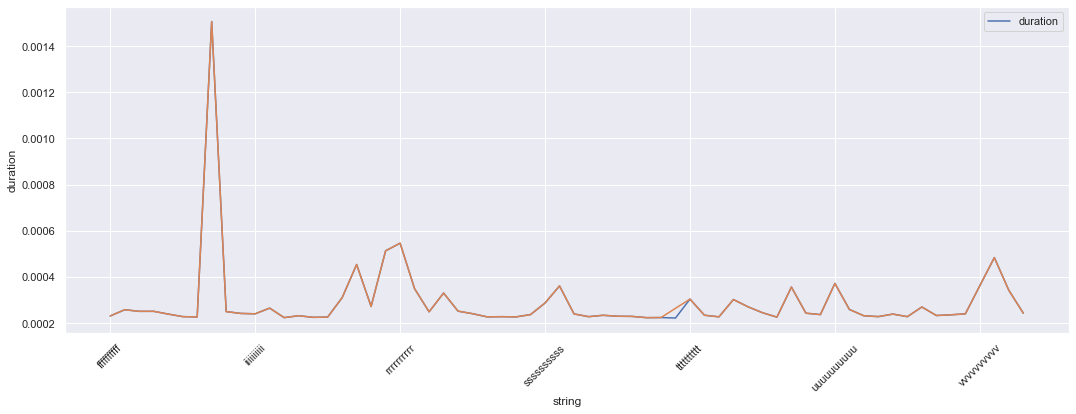

In [35]:
ax = df10.plot(figsize=(18,6))
df10[df10['duration']> .000222]['duration'].plot(figsize=(18,6))
# not mapping strings to duration correctly
plt.xticks(rotation=45)
ax.set_xticklabels(df[df['duration']> .000222]['string'])
#ax.set_xticklabels(df.string.to_list())
# not working as I expected
# ax.set_xlabel(df.string.to_list())
ax.set_xlabel('string')
ax.set_ylabel('duration')

<AxesSubplot:xlabel='duration', ylabel='Density'>

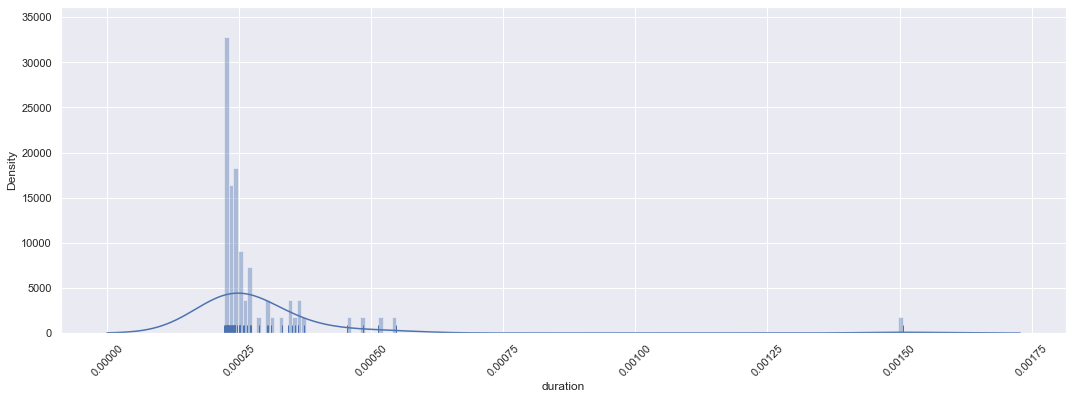

In [36]:
sns.set(rc={'figure.figsize':(18,6)})
plt.xticks(rotation=45)
sns.distplot(df10['duration'],bins=150, rug=True, kde=True)

## How does this compare to a constant time return?

Now lets add a buffer of time to the outputs. I don't 

In [37]:
def comparehashconstant(token, secret):
    """
    we're going to use the old md5 hash to simplify the demonstration
    and add a wait before returning either a match or a failure.
    Buffering in a dumb way, but this should make it harder to determine the validity of a guess.
    """
    htoken, hsecret = hashlib.md5(token.encode('utf-8')), hashlib.md5(secret.encode('utf-8'))
    one, two = list(htoken.hexdigest()), list(hsecret.hexdigest())
    for x in range(0,len(one)):
        if one[x] == two[x]:
            time.sleep(.001)
            pass
        else:
            time.sleep(.02)
            return False
    time.sleep(.01)
    return True

In [38]:
totals=[]
for loop in range(1000):
    stash11 = {}
    for l in valid_chars:
        mystr = l *10
        start = attotime.attodatetime.now()
        comparehashconstant(mystr, mysecret)
        end = attotime.attodatetime.now()
        duration = end - start
        stash11[mystr] = str(duration)

In [39]:
sorted(stash11.items(), key=lambda x: x[1])[-10:]

[('2222222222', '0:00:00.0242149829864502'),
 ('OOOOOOOOOO', '0:00:00.0242161750793457'),
 ('VVVVVVVVVV', '0:00:00.02432489395141602'),
 ('KKKKKKKKKK', '0:00:00.0244133472442627'),
 ('XXXXXXXXXX', '0:00:00.0247349739074707'),
 ('pppppppppp', '0:00:00.02481603622436524'),
 ('FFFFFFFFFF', '0:00:00.02485299110412598'),
 ('__________', '0:00:00.02506589889526367'),
 ('nnnnnnnnnn', '0:00:00.02530097961425781'),
 ('xxxxxxxxxx', '0:00:00.02539587020874024')]

In [40]:
df10[df10['string'] == 'rrrrrrrrrr']

,string,duration
17,rrrrrrrrrr,0.000454


In [41]:
df11 = pd.DataFrame(stash11.items())

In [42]:
df11.columns = ['string', 'duration']

In [43]:
df11['duration'] = df11['duration'].apply(fixtimes)

**The plots are all over the place, but none of the top 10 chars are 'r'. First letter guessing is obfuscated.**

first letter 'r' is the 17th hit. 

In [44]:
mysecret

'rMAwzI_52tVSvgKzRo3PJ0G7_Danw7jlaZ-6vTkOUiQ'

In [45]:
df11.sort_values(by='duration', ascending=False)[:10]

,string,duration
23,xxxxxxxxxx,0.025396
13,nnnnnnnnnn,0.025301
63,__________,0.025066
31,FFFFFFFFFF,0.024853
15,pppppppppp,0.024816
49,XXXXXXXXXX,0.024735
36,KKKKKKKKKK,0.024413
47,VVVVVVVVVV,0.024325
40,OOOOOOOOOO,0.024216
54,2222222222,0.024215


In [46]:
df11[df11['string'] == 'rrrrrrrrrr']

,string,duration
17,rrrrrrrrrr,0.024012


Text(0, 0.5, 'duration')

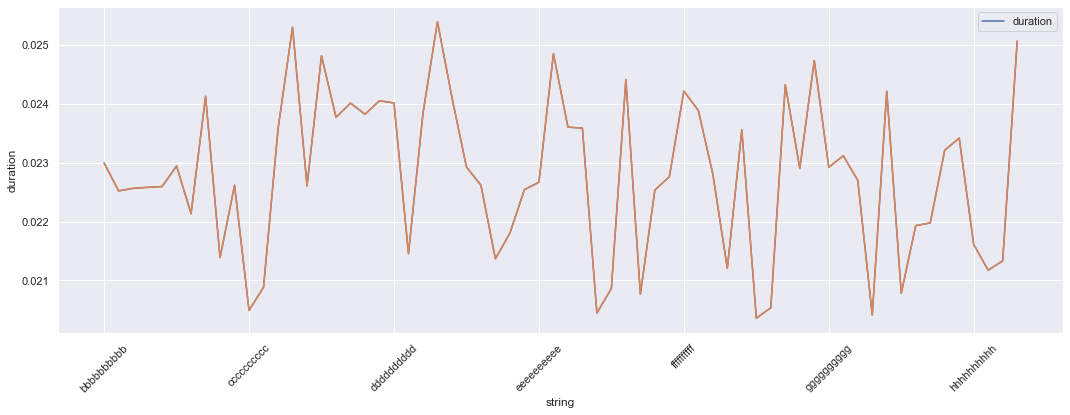

In [47]:
ax = df11.plot(figsize=(18,6))
df11['duration'].plot(figsize=(18,6))
# not mapping strings to duration correctly
plt.xticks(rotation=45)
ax.set_xticklabels(df11['string'])
#ax.set_xticklabels(df.string.to_list())
# not working as I expected
# ax.set_xlabel(df.string.to_list())
ax.set_xlabel('string')
ax.set_ylabel('duration')

<AxesSubplot:xlabel='duration', ylabel='Density'>

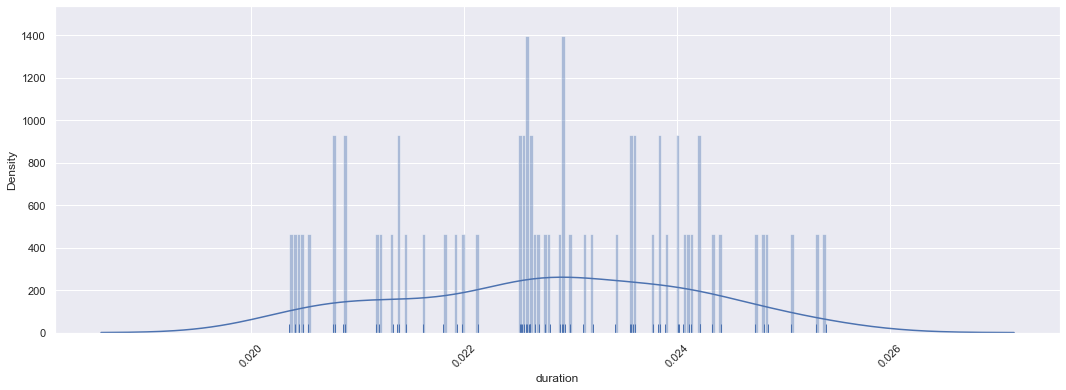

In [48]:
sns.set(rc={'figure.figsize':(18,6)})
plt.xticks(rotation=45)
sns.distplot(df11['duration'],bins=150, rug=True, kde=True)